# Exercise 5 -  GCommands Dataset

Shmuel Amar - 303094809 | Moshe Binieli - 311800668

## Intro:

to solve this voice multiclass task we used ResNet - a well known and currently holds SOTA or almost-SOTA results on many datasets, including image voice and others.

![ResNet](resnet_image.png)

**We've experimented with many ResNet architectures available by PyTorch:**

1. ResNet18
2. ResNet101
3. ResNet152
4. ResNext
5. WideResNet
6. ResNet with dilation

**Key thoughts we had during architecture selection experiments:**

1. ResNet18 with bottleneck performs similarly to ResNet101 & ResNet152 - so we just used it instead of the larger network variants
2. adding gaussian noise to input improves performance
3. stacking - we can stack 5 different variants of resnet into single classifier (ensemble)
4. ResNet implementation on PyTorch built for image and not for voice so we need to adapt the input dimensions

**Training process**

We've manually experimented with hyper-params (harder to tune large models on large datasets under time constraints).

1. **Early stopping / patience:** train network until consecutive 7 epochs no validation loss improvement and takes best epoch
2. **Noise:** add random gaussian noise (mean=0, stddev=0.2) to each sample
3. **GPU:** train on colab with GPU (2 mins vs 50 mins on cpu per epoch)
4. **Stacking:** repeat 5 times with different resnet variants to get 5 different models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
from glob import glob

MODELS = [
    'resnet18-bottleneck',
    'resnet18-basic',
    'resnext18',
    'resnet-wide',
    'resnet18-dilation',
    'stacked-net',
]

# load stats saved from running the models
dfs = []
for i, stats_fname in enumerate(sorted(glob('./models/*net*/stats.json'))):
    with open(stats_fname) as fp:
        dfi = pd.DataFrame(json.load(fp))
        dfi['model'] = MODELS[i]
        dfi['epoch'] = range(1, len(dfi)+1)
        dfs.append(dfi)

df = pd.concat(dfs, sort=False).reset_index(drop=True)
df = df.sort_values(['epoch', 'model'])
df.drop(columns='epoch').head(6)

,train_loss,val_loss,train_acc,val_acc,best_epoch,model
44,0.961471,0.858074,0.709367,0.765666,18,resnet-wide
13,0.781203,0.611927,0.767867,0.812151,5,resnet18-basic
0,0.959511,0.702196,0.710767,0.811121,5,resnet18-bottleneck
70,1.015606,1.088289,0.697267,0.691821,19,resnet18-dilation
26,1.183198,0.769766,0.648300,0.775816,10,resnext18
97,3.318398,3.207664,0.204178,0.429538,166,stacked-net


## ResNets Performance

**we stacked 5 networks as follows:**

1. ResNet18 with bottleneck modules
2. ResNet18 with basic modules
3. ResNext18
4. ResNet wide
5. ResNet18 with dillation

We can see that each model perform pretty good but the stacked network performed even better!

In [2]:
print('Best Stats Per Model:')
df.groupby('model').max().drop(columns='epoch')

Best Stats Per Model:


,train_loss,val_loss,train_acc,val_acc,best_epoch
model,,,,,
resnet-wide,0.961471,0.858074,0.991467,0.929685,18
resnet18-basic,0.781203,0.652887,0.989767,0.913210,5
resnet18-bottleneck,0.959511,0.704428,0.982500,0.923801,5
resnet18-dilation,1.015606,1.088289,0.993200,0.940424,19
resnext18,1.183198,0.769766,0.987067,0.911445,10
stacked-net,3.318398,3.207664,0.970580,0.952927,166


## ResNet Trainings Stats

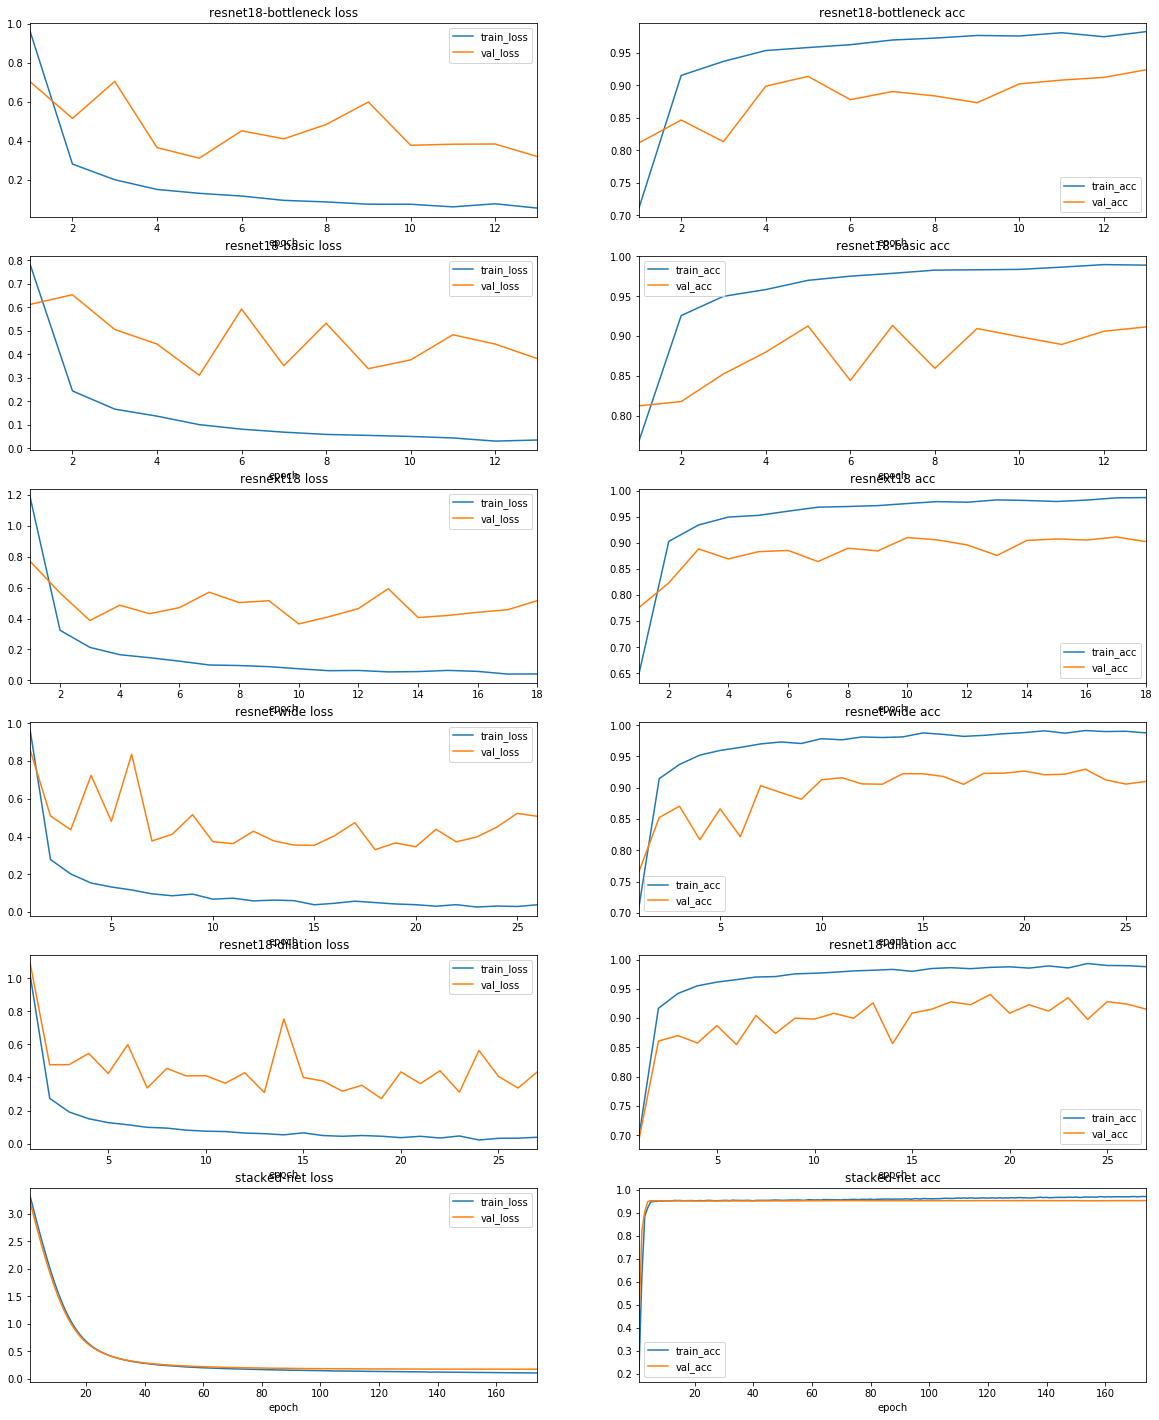

In [3]:
fig, ax = plt.subplots(6,2, figsize=(20,25))

for i, model in enumerate(MODELS, 1):
    for j, key in enumerate(('loss', 'acc')):
        mdf = df[df['model'] == model][[f'train_{key}', f'val_{key}', 'epoch']]
        mdf.plot.line(x='epoch', ax=ax[i-1, j], title=f'{model} {key}')

## Stacking The 5 ResNets Models Together

Combining these 5 networks gave the best performance both on test and train.

We used another linear classifier of shape `(NUM_MODELS*NUM_CLASSES, NUM_CLASSES)`

Trained it similarly to the other models with the input are the logits of all the 5 ResNets and the output is the final prediction.

We used also small random gaussian noise to the input to add some regularization for better generalization.

In [4]:
import torch
torch.load('stacked_net/final.pt')

W = torch.load('models/stacked_net/final.pt', 'cpu')['fc1.weight'].numpy().T.reshape(5, 30, 30)
stacked_w = W[:, np.arange(30), np.arange(30)].T
print(stacked_w.shape)

(30, 5)


In [5]:
net_weights = (stacked_w / stacked_w.sum(axis=1)[:, None]).round(2)
net_contrib = (net_weights.sum(axis=0) / net_weights.sum()).round(4)
print('average model contribution to predictions:')
dict(zip(MODELS, net_contrib))

average model contribution to predictions:


{'resnet18-bottleneck': 0.1967,
 'resnet18-basic': 0.1951,
 'resnext18': 0.1924,
 'resnet-wide': 0.2027,
 'resnet18-dilation': 0.2131}

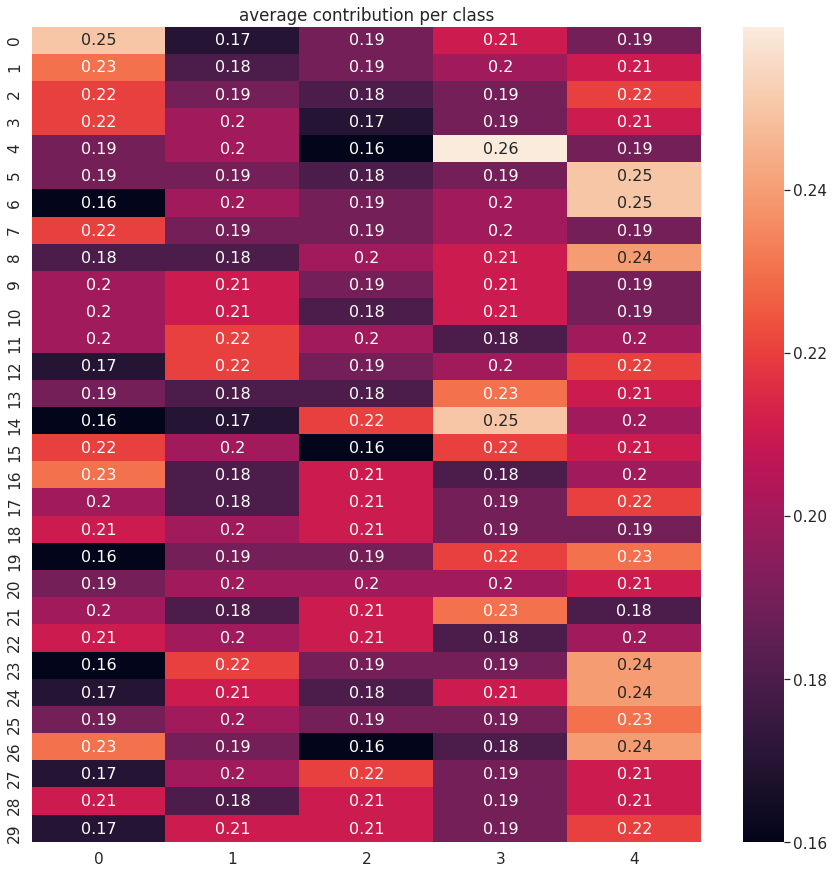

In [6]:
plt.figure(figsize=(15, 15))
sns.set(font_scale=1.4)  # for label size
ax = sns.heatmap(net_weights, annot=True, annot_kws={'size': 16}, fmt='g')
ax.set_title('average contribution per class')
plt.show()

## Final Conclusions

We can see that each model performs good but together they perform better and the validation loss is more smooth and close to the actual loss with also less overfit.

Its very interesting why training a large network with 5 "towers" of resnet or even 2 followed by linear layer perform **worse** than single resnet. But when stacking together multiple ResNets trained we get increase in performance.

Does the gradient vanish or local minimum is reached? sounds like a good idea for a research :)